In [5]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import impute, preprocessing, model_selection, base, metrics, linear_model, pipeline, ensemble, svm, multiclass, neighbors, compose, datasets, decomposition, manifold
import tensorflow as tf
from tensorflow import keras
# import tensorflow_datasets as tfds
import cv2
from custom_objects import decorators

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
cifar10 = keras.datasets.cifar10.load_data()

(X_train, y_train), (X_test, y_test) = (cifar10[0][0], cifar10[0][1]), (cifar10[1][0], cifar10[1][1])

In [8]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [9]:
X_valid, y_valid = X_train[40000:], y_train[40000:]
X_train, y_train = X_train[:40000], y_train[:40000]

In [10]:
def plot_classes(X, y=None, rows=2, columns=5, class_names=None):
    fig, axes = plt.subplots(rows, columns, figsize=(10,4))
    if y is None:
        classes = list(range(0,9))
    else:
        y = y.reshape(-1,)
        classes = np.unique(y)
    if class_names is None:
        class_names = classes
    for class_name, class_, axis in zip(class_names, classes, axes.flat):
        image = X[y==class_][0]
        axis.imshow(image)
        axis.set_title(class_)
        axis.axis('off')

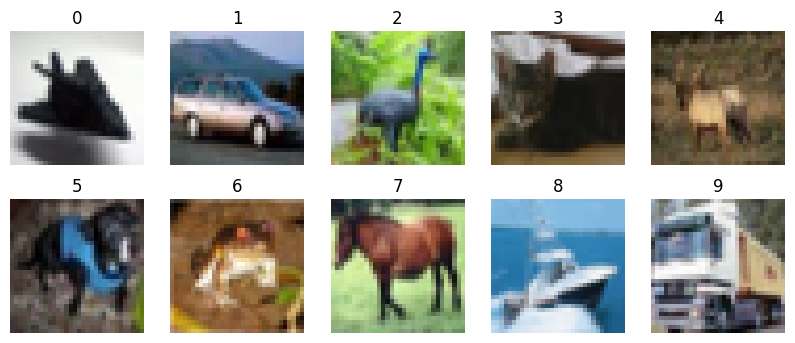

In [11]:
plot_classes(X_train, y_train)

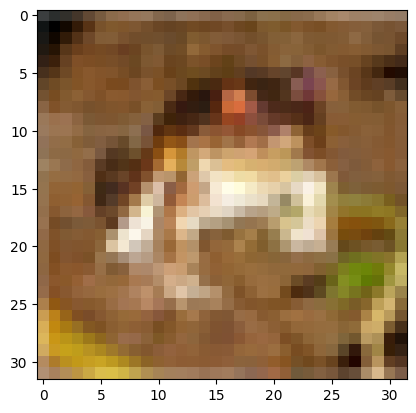

In [12]:
plt.imshow(X_train[0])

**MODEL**

I have created a Sequential Model with 20 hidden layers, each contains 100 neurons. The _activation function_ used is **ELU** with **He Normal** _kernel initialization_.
The output layer use **softmax** _activation function_ for 10 classes.

In [17]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [25]:
 
hidden = []

for i in range(20):
    hidden.append(keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'))

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(32,32,3)),
    keras.layers.Flatten(),
    *hidden,
    keras.layers.Dense(10, activation='softmax')
])

In [14]:
import os
root_logdir = os.path.join(os.curdir, 'my_logs')

def get_run_logdir():
    import time
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

**COMPILING AND TRAINING**

I have used **Nadam** optimizer with a _learning rate = 0.0005_. I also have used a **Performance Scheduler** as the _learning rate schedule_ which reduces my learning rate to 3/4 everytime the model's validation loss does not improve for 10 epochs. The loss and metrics used are too obvious to explain.

Along with this, I use two callbacks - **Early stopping** with a patience of 10, and **Tensorboard** for visualizing learning curves.
We will run for 100 epochs and leave it to the Early Stopping callback to stop training and return the best weights.

In [26]:
   
optimizer = keras.optimizers.Nadam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

run_logdir = get_run_logdir()
tensorboard = keras.callbacks.TensorBoard(log_dir=run_logdir)
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [28]:

# Your code here for models, training, etc.    
model.fit(X_train, y_train, epochs=4, callbacks=[early_stopping, tensorboard], validation_split=0.2)

Epoch 1/4
1000/1000 [==============================] - 7s 7ms/step - loss: 1.8149 - accuracy: 0.3334 - val_loss: 1.7954 - val_accuracy: 0.3392
Epoch 2/4
1000/1000 [==============================] - 7s 7ms/step - loss: 1.7827 - accuracy: 0.3507 - val_loss: 1.7867 - val_accuracy: 0.3462
Epoch 3/4
1000/1000 [==============================] - 7s 7ms/step - loss: 1.7532 - accuracy: 0.3615 - val_loss: 1.7715 - val_accuracy: 0.3514
Epoch 4/4
1000/1000 [==============================] - 6s 6ms/step - loss: 1.7398 - accuracy: 0.3663 - val_loss: 1.7470 - val_accuracy: 0.3627


In [16]:
print(model.evaluate(X_valid, y_valid))

313/313 [==============================] - 0s 1ms/step - loss: 1.8431 - accuracy: 0.3262
[1.8430570363998413, 0.326200008392334]


In [16]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Launching TensorBoard...

![Adam Optimizer](./images/adam_0005_small.png)

Learning Curve for the above run

Let us try **Batch Normalization**

In [20]:
tf.random.set_seed(42)

model_bn = tf.keras.Sequential()
model_bn.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model_bn.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model_bn.add(tf.keras.layers.BatchNormalization())
    model_bn.add(tf.keras.layers.Activation("swish"))

model_bn.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model_bn.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='my_logs/model_checkpoints/model_bn.h5', save_best_only=True)

In [21]:
history = model_bn.fit(X_train, y_train, epochs=100,validation_split=0.3 , callbacks=[early_stopping_cb, tensorboard, model_checkpoint_cb])

Epoch 1/100
875/875 [==============================] - 52s 51ms/step - loss: 2.1278 - accuracy: 0.2117 - val_loss: 2.0745 - val_accuracy: 0.2428
Epoch 2/100
875/875 [==============================] - 95s 108ms/step - loss: 1.8676 - accuracy: 0.3192 - val_loss: 2.0983 - val_accuracy: 0.2508
Epoch 3/100
875/875 [==============================] - 145s 165ms/step - loss: 1.7570 - accuracy: 0.3685 - val_loss: 1.8977 - val_accuracy: 0.3205
Epoch 4/100
875/875 [==============================] - 122s 139ms/step - loss: 1.6821 - accuracy: 0.3963 - val_loss: 1.7904 - val_accuracy: 0.3583
Epoch 5/100
875/875 [==============================] - 118s 134ms/step - loss: 1.6226 - accuracy: 0.4231 - val_loss: 1.9626 - val_accuracy: 0.3338
Epoch 6/100
875/875 [==============================] - 121s 139ms/step - loss: 1.5812 - accuracy: 0.4363 - val_loss: 1.6882 - val_accuracy: 0.4024
Epoch 7/100
875/875 [==============================] - 136s 156ms/step - loss: 1.5398 - accuracy: 0.4525 - val_loss: 1.67


KeyboardInterrupt



In [129]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_selu_model", save_best_only=True)

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 32*32*3)).reshape(-1, 32,32,3)

history_2 = model.fit(X_train_scaled, y_train, epochs=100,
          validation_split=0.3,
          callbacks=callbacks)

ValueError: Data cardinality is ambiguous:
  x sizes: 10000
  y sizes: 50000
Make sure all arrays contain the same number of samples.